# Measurement in Biomedical image Analysis
> In this chapter, you'll get to the heart of image analysis: object measurement. Using a 4D cardiac time series, you'll determine if a patient is likely to have heart disease. Along the way, you'll learn the fundamentals of image segmentation, object labeling, and morphological measurement. This is the Summary of lecture "Biomedical Image Analysis in Python", via datacamp.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Datacamp, Vision]
- image: 

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import imageio
import imageio.v2 as imageio
import scipy.ndimage as ndi

plt.rcParams['figure.figsize'] = (10, 8)

## Objects and Labels


### Segment the heart
In this chapter, we'll work with [magnetic resonance (MR)](https://en.wikipedia.org/wiki/Magnetic_resonance_imaging) imaging data from the [Sunnybrook Cardiac Dataset](http://www.cardiacatlas.org/studies/sunnybrook-cardiac-data/). The full image is a 3D time series spanning a single heartbeat. These data are used by radiologists to measure the ejection fraction: the proportion of blood ejected from the left ventricle during each stroke.

To begin, segment the left ventricle from a single slice of the volume (`im`). First, you'll filter and mask the image; then you'll label each object with `ndi.label()`.

In [25]:
def format_and_render_plot():
    'Custom function to simplify common formatting operations for exercises.'
    
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    fig = plt.gcf()
    ax = fig.axes[0]
    ax.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(ax.get_images()[0], cax=cax)
    plt.sca(ax)
    plt.show()

Num. Labels: 26


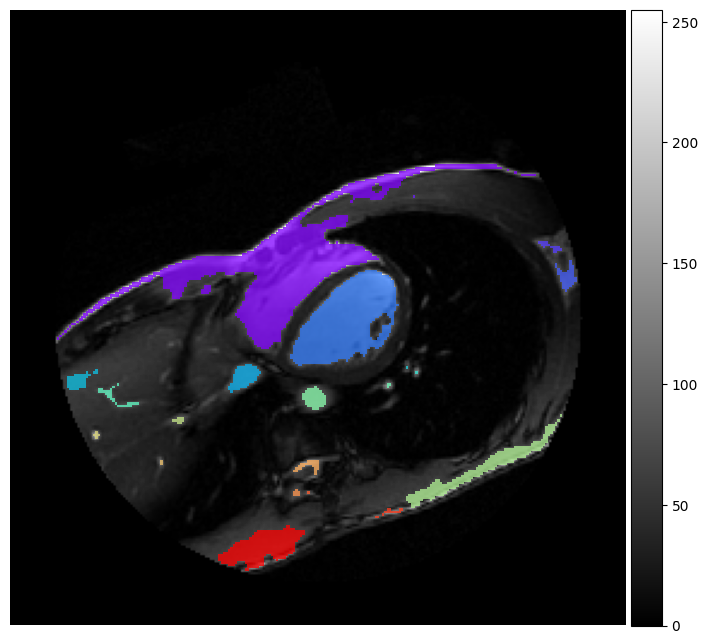

In [26]:
im = imageio.imread('./dataset/sunnybrook-cardiac-mr/SCD2001_006/SCD2001_MR_117.dcm')
im = im.astype('float64')

# Smooth intensity values
im_filt = ndi.median_filter(im, size=3)

# Select high-intensity pixels
mask_start = np.where(im_filt > 60, 1, 0)
mask = ndi.binary_closing(mask_start)

# Label the objects in "mask"
labels, nlabels = ndi.label(mask)
print('Num. Labels:', nlabels)

# Create a labels overlay
overlay = np.where(labels > 0, labels, np.nan)

# Use imshow to plot the overlay
plt.imshow(im, cmap='gray');
plt.imshow(overlay, cmap='rainbow', alpha=0.75);
format_and_render_plot()

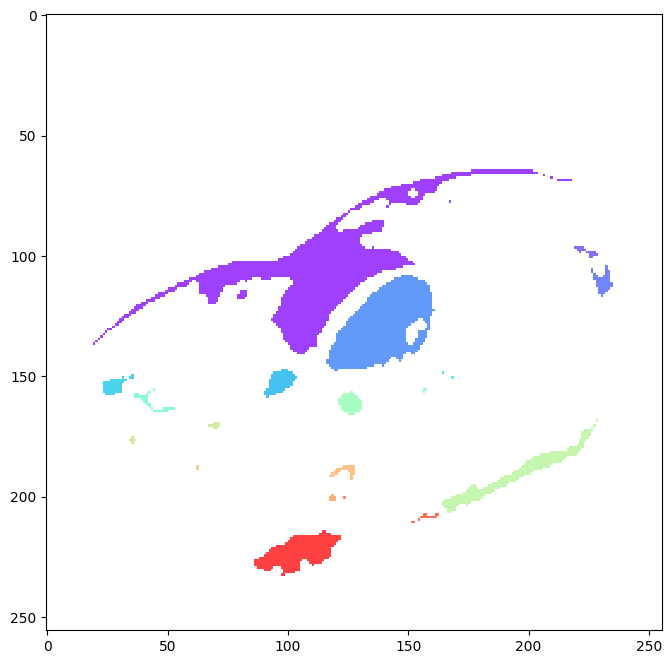

In [27]:
# Create a `labels` overlay
overlay = np.where(labels > 0, labels, np.nan)

# Use imshow to plot the overlay
plt.imshow(overlay, cmap='rainbow', alpha=0.75)
# format_and_render_plot(

http://www.cardiacatlas.org/studies/sunnybrook-cardiac-data/
https://en.wikipedia.org/wiki/Magnetic_resonance_imaging


### Select objects
Labels are like object "handles" - they give you a way to pick up whole sets of pixels at a time. To select a particular object:

1. Find the label value associated with the object.
2. Create a mask of matching pixels.

For this exercise, create a labeled array from the provided `mask`. Then, find the label value for the centrally-located left ventricle, and create a mask for it.

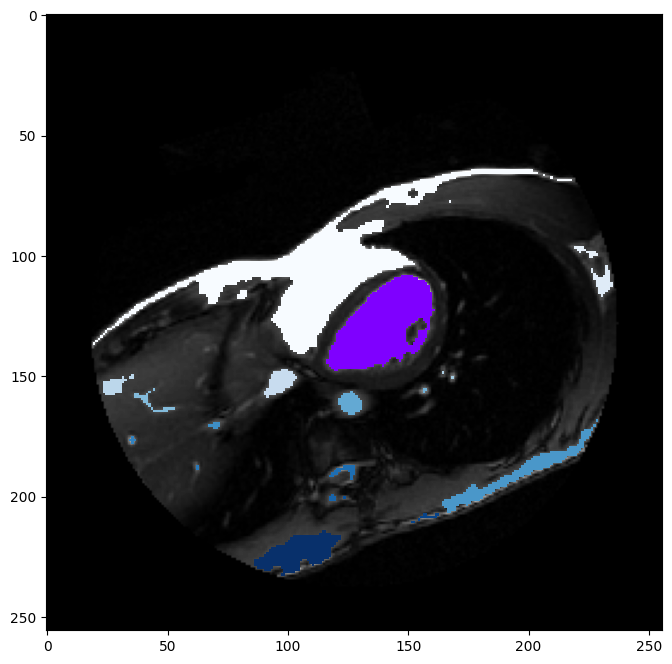

In [28]:
# Label the image "mask"
labels, nlabels = ndi.label(mask)

# Select left ventricle pixels
lv_val = labels[128, 128]
lv_mask = np.where(labels == lv_val, 1, np.nan)

# Overlay selected label
plt.imshow(im, cmap='gray');
plt.imshow(overlay, cmap='Blues');
plt.imshow(lv_mask, cmap='rainbow');

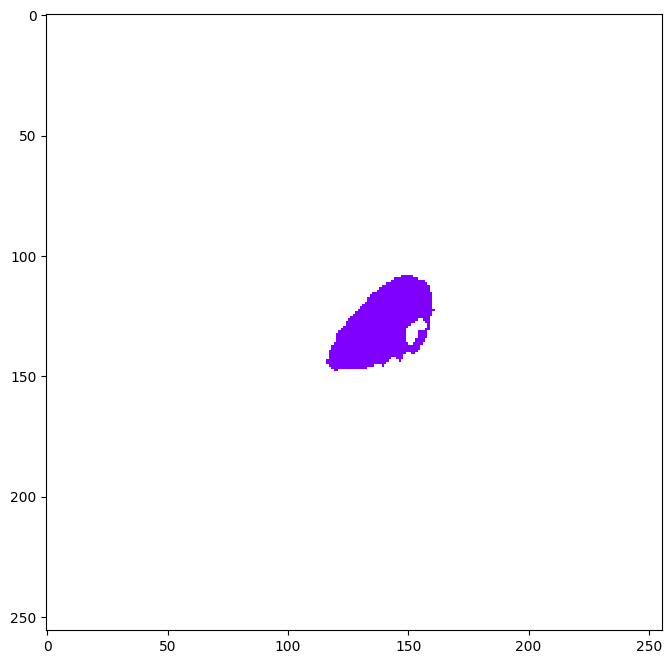

In [29]:
# Label the image "mask"
labels, nlabels = ndi.label(mask)

# Select left ventricle pixels
lv_val = labels[128, 128]
lv_mask = np.where(labels == lv_val, 1, np.nan)

# Overlay selected label
plt.imshow(lv_mask, cmap='rainbow')
plt.show()

In [30]:
# Create left ventricle mask
labels, nlabels = ndi.label(mask)
lv_val = labels[128, 128]
lv_mask = np.where(labels == lv_val, 1, 0)

# Find bounding box of left ventricle
bboxes = ndi.find_objects(lv_mask)
print('Number of objects:', len(bboxes))
print('Indices for first box:', bboxes[0])

Number of objects: 1
Indices for first box: (slice(107, 149, None), slice(116, 162, None))


Number of objects: 1
Indices for first box: (slice(107, 149, None), slice(116, 162, None))


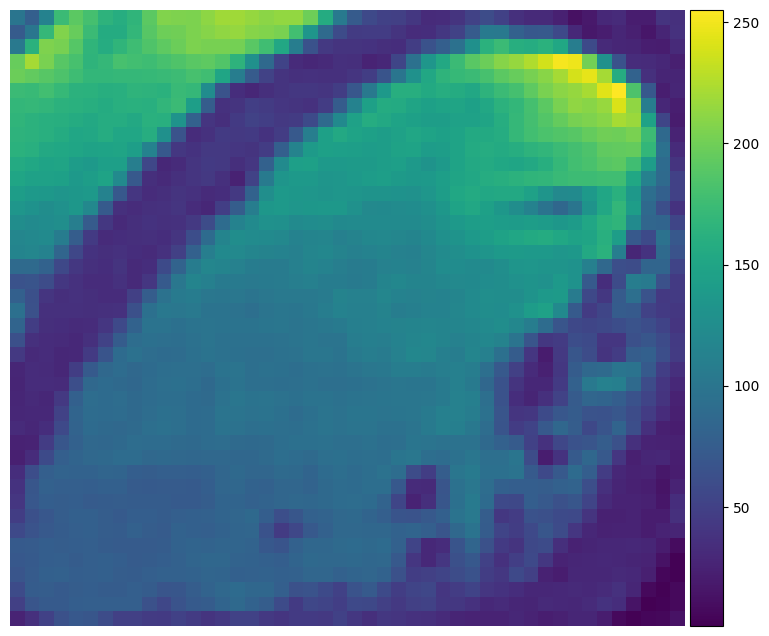

In [31]:
# Create left ventricle mask
labels, nlabels = ndi.label(mask)
lv_val = labels[128, 128]
lv_mask = np.where(labels == lv_val, 1, 0)

# Find bounding box of left ventricle
bboxes = ndi.find_objects(lv_mask)
print('Number of objects:', len(bboxes))
print('Indices for first box:', bboxes[0])

# Crop to the left ventricle (index 0)
im_lv = im[bboxes[0]]

# Plot the cropped image
plt.imshow(im_lv)
format_and_render_plot()

### Extract objects
Extracting objects from the original image eliminates unrelated pixels and provides new images that can be analyzed independently.

The key is to crop images so that they only include the object of interest. The range of pixel indices that encompass the object is the [bounding box](https://en.wikipedia.org/wiki/Minimum_bounding_box).

For this exercise, use `ndi.find_objects()` to create a new image containing only the left ventricle.



In [32]:
def format_and_render_plot():
    '''Custom function to simplify common formatting operations for exercises. 
    Operations include: 
    1. Looping through `fig.axes` and turning off axis grid.
    2. Calling `plt.tight_layout` to improve subplot spacing.
    3. Calling `plt.show()` to render plot.'''
    fig = plt.gcf()
    for ax in fig.axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Number of objects: 1
Indices for first box: (slice(107, 149, None), slice(116, 162, None))


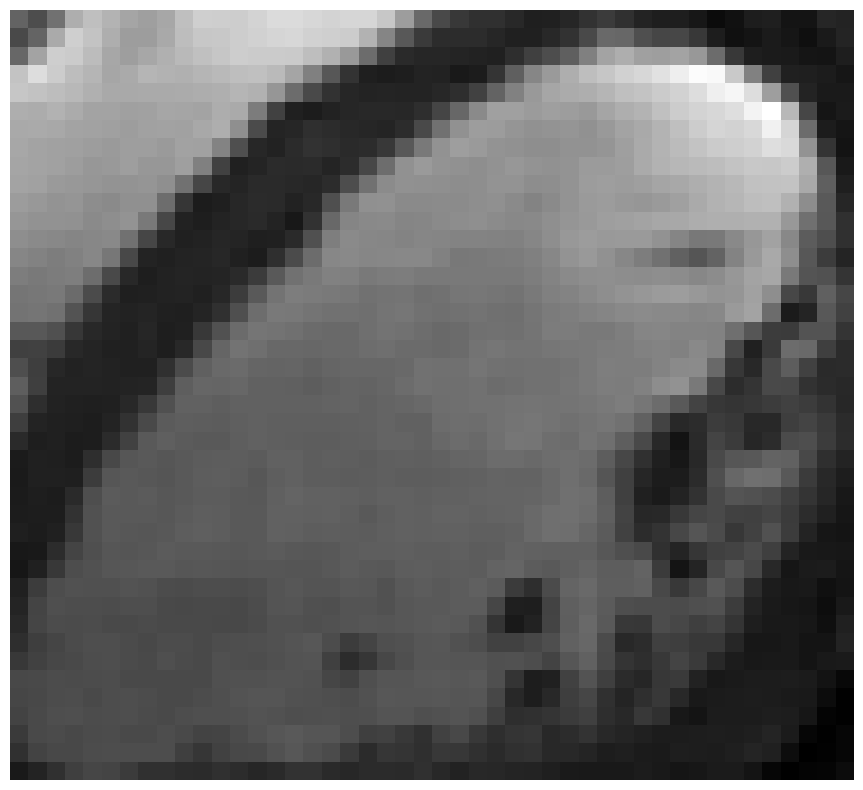

In [33]:
# Create left ventricle mask
lv_val = labels[128, 128]
lv_mask = np.where(labels == lv_val, 1, 0)

# Find bounding box of left ventricle
bboxes = ndi.find_objects(lv_mask)
print('Number of objects:', len(bboxes))
print('Indices for first box:', bboxes[0])

# Crop to the left ventricle (index 0)
im_lv = im[bboxes[0]]

# Plot the cropped image
plt.imshow(im_lv, cmap='gray');
format_and_render_plot();

## Measuring intensity


### Measure variance
SciPy measurement functions allow you to tailor measurements to specific sets of pixels:

- Specifying `labels` restricts the mask to non-zero pixels.
- Specifying `index` value(s) returns a measure for each label value.

For this exercise, calculate the intensity variance of `vol` with respect to different pixel sets. We have provided the 3D segmented image as `labels`: label 1 is the left ventricle and label 2 is a circular sample of tissue.
![vol](image/Ch3_L4_cardiac-vol-exercise.gif)

In [42]:
vol = imageio.volread('./dataset/sunnybrook-cardiac-mr/SCD2001_003/SCD2001_MR_142.dcm', )
labels, nlabels = ndi.label(vol)

# Variance for all pixels
var_all = ndi.variance(vol, labels=None, index=None)
print('All pixels:', var_all)

# Variance for labeled pixels
var_labels = ndi.variance(vol, labels=labels)
print('Labeled pixels:', var_labels)

# Variance for each object
var_objects = ndi.variance(vol, labels=labels, index=[1, 2])
print('Left ventricle:', var_objects[0])
print('Ohter tissue:', var_objects[1])

Reading DICOM (examining files): 1/21 files (4.8%)

21/21 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 21/21  (100.0%)
All pixels: 967.49703735864
Labeled pixels: 1460.1399776746694
Left ventricle: 7.281277061124523
Ohter tissue: 1462.5236145435408


In [43]:
# Variance for all pixels
var_all = ndi.variance(vol, labels=None, index=None)
print('All pixels:', var_all)

# Variance for labeled pixels
var_labels = ndi.variance(vol, labels, index=None)
print('Labeled pixels:', var_labels)

# Variance for each object
var_objects = ndi.variance(vol, labels, index=[1,2])
print('Left ventricle:', var_objects[0])

print('Other tissue:', var_objects[1])

All pixels: 967.49703735864
Labeled pixels: 1460.1399776746694
Left ventricle: 7.281277061124523
Other tissue: 1462.5236145435408


### Separate histograms
A poor tissue segmentation includes multiple tissue types, leading to a wide distribution of intensity values and more variance.

On the other hand, a perfectly segmented left ventricle would contain only blood-related pixels, so the histogram of the segmented values should be roughly bell-shaped.

For this exercise, compare the intensity distributions within `vol` for the listed sets of pixels. Use `ndi.histogram`, which also accepts `labels` and `index` arguments.

In [44]:
def format_and_render_plot():
    '''Custom function to simplify common formatting operations for exercises. 
    Operations include: 
    1. Calling `plt.legend()`
    2. Calling `plt.show()` to render plot.'''
    plt.legend()
    plt.xlabel('Intensity Value')
    plt.ylabel('Proportion of Image')
    plt.ylim([0, 0.03])
    plt.show()

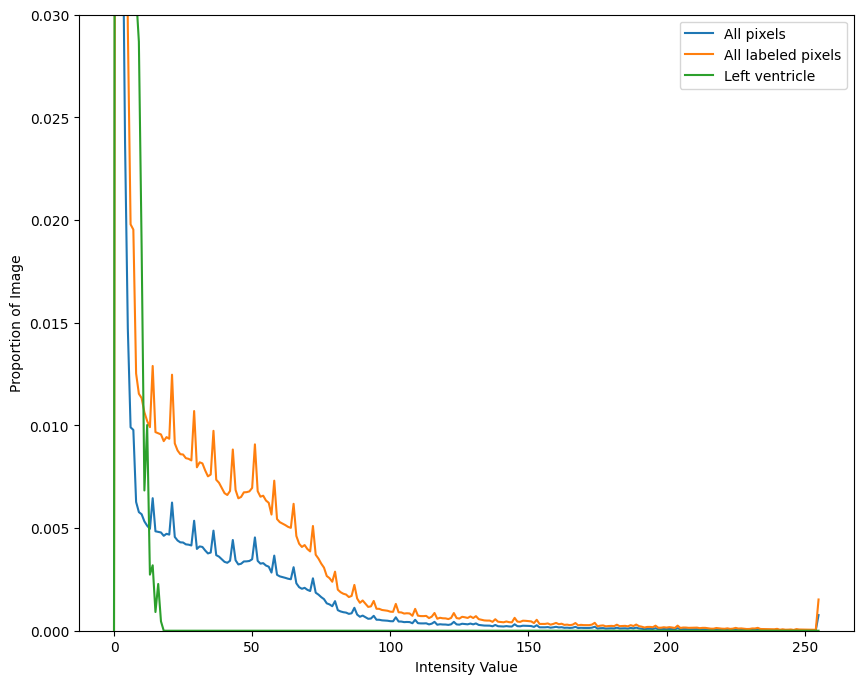

In [45]:
# Create histogram for selected pixels
hist1 = ndi.histogram(vol, min=0, max=255, bins=256)
hist2 = ndi.histogram(vol, 0, 255, 256, labels=labels)
hist3 = ndi.histogram(vol, 0, 255, 256, labels=labels, index=1)

# Plot the histogram density
plt.plot(hist1 / hist1.sum(), label='All pixels')
plt.plot(hist2 / hist2.sum(), label='All labeled pixels')
plt.plot(hist3 / hist3.sum(), label='Left ventricle')
format_and_render_plot()

## Measuring morphology
- Spatial extent is the product of:
    1. Space occupied by each element
    2. Number of array elements

### Calculate volume
Quantifying tissue morphology, or shape is one primary objective of biomedical imaging. The size, shape, and uniformity of a tissue can reveal essential health insights.

For this exercise, measure the volume of the left ventricle in one 3D image (`vol`).

First, count the number of voxels in the left ventricle (label value of 1). Then, multiply it by the size of each voxel in ${mm}^3$. (Check `vol.meta` for the sampling rate.)

In [46]:
# Calculate volume per voxel
d0, d1, d2 = vol.meta['sampling']
dvoxel = d0 * d1 * d2

# Count label voxels
nvoxels = ndi.sum(1, labels, index=1)

# Calculate volume of label
volume = nvoxels * dvoxel
print(volume)

0.0


### Calculate distance
A distance transformation calculates the distance from each pixel to a given point, usually the nearest background pixel. This allows you to determine which points in the object are more interior and which are closer to edges.

For this exercise, use the [Euclidian distance](https://en.wikipedia.org/wiki/Euclidean_distance) transform on the left ventricle object in `labels`.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Max distance (mm): 2.734376
Max location: (0, 32, 82)


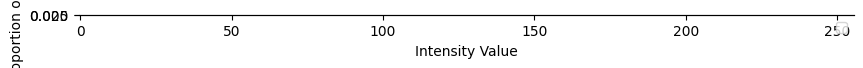

In [47]:
# Calculate left ventricle distances
lv = np.where(labels == 1, 1, 0)
dists = ndi.distance_transform_edt(lv, sampling=vol.meta['sampling'])

# Report on distances
print('Max distance (mm):', ndi.maximum(dists))
print('Max location:', ndi.maximum_position(dists))

# Plot overlay of distances
overlay = np.where(dists[5] > 0, dists[5], np.nan) 
plt.imshow(overlay, cmap='hot')
format_and_render_plot()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Max distance (mm): 2.734376
Max location: (0, 32, 82)


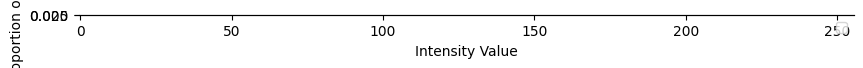

In [50]:
# Calculate left ventricle distances
lv = np.where(labels == 1, 1, 0)
dists = ndi.distance_transform_edt(lv, sampling=vol.meta['sampling'])

# Report on distances
print('Max distance (mm):', ndi.maximum(dists))
print('Max location:', ndi.maximum_position(dists))

# Plot overlay of distances
overlay = np.where(dists[5] > 0, dists[5], np.nan) 
plt.imshow(overlay, cmap='hot')
format_and_render_plot()

AttributeError: 'numpy.ndarray' object has no attribute 'meta'

### Pinpoint center of mass
The distance transformation reveals the most embedded portions of an object. On the other hand, `ndi.center_of_mass()` returns the coordinates for the center of an object.

The "mass" corresponds to intensity values, with higher values pulling the center closer to it.

For this exercise, calculate the center of mass for the two labeled areas. Then, plot them on top of the image.

Label 1 center: (10.108141218398485, 34.21561421093663, 80.40951108141219)
Label 2 center: (10.1102075014576, 140.13919266526412, 122.52727232216047)


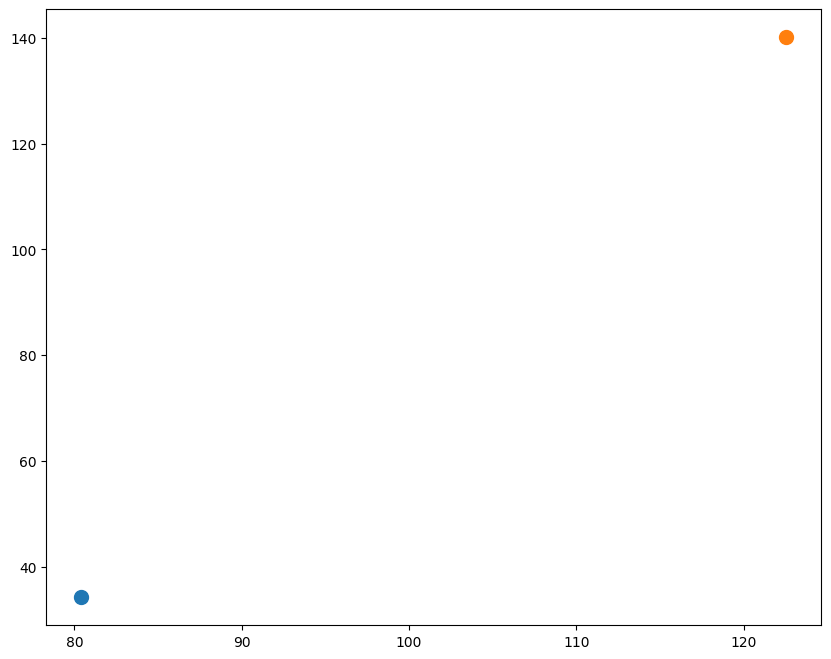

In [48]:
# Extract centers of mass for objects 1 and 2
coms = ndi.center_of_mass(vol, labels, index=[1,2])
print('Label 1 center:', coms[0])
print('Label 2 center:', coms[1])

# Add marks to plot
for c0, c1, c2 in coms:
    plt.scatter(c2, c1, s=100, marker='o')
plt.show()

## Measuring in time
- Ejection fraction
$$ \frac{{LV}_{max} - {LV}_{min}}{{LV}_{max}} $$
    - Procedure
        1. Segment left ventricle
        2. For each 3D volume in the time series, calculate volume
        3. Select minimum and maximum
        4. Calculate ejection fraction

### Summarize the time series
The [ejection fraction](https://en.wikipedia.org/wiki/Ejection_fraction) is the proportion of blood squeezed out of the left ventricle each heartbeat. To calculate it, radiologists have to identify the maximum volume (systolic volume) and the minimum volume (diastolic volume) of the ventricle.
![ejection](image/Ch3_L4_cardiac-ts-exercise.gif)

For this exercise, create a time series of volume calculations. There are 20 time points in both `vol_ts` and labels. The data is ordered by `(time, plane, row, col)`.




In [54]:
# Create an empty time series
ts = np.zeros(20)

# Calculate volume at each voxel
d0, d1, d2, d3 = vol_ts.meta['sampling']
dvoxel = d1 * d2 * d3

# Loop over the labeled arrays
for t in range(20):
    nvoxels = ndi.sum(1, labels[t], index=1)
    ts[t] = nvoxels * dvoxel

# Plot the data
plt.plot(ts)
format_and_render_plot()

SyntaxError: 'tuple' is an illegal expression for augmented assignment (342618471.py, line 5)

### Measure ejection fraction
The ejection fraction is defined as:

$$ \frac{V_{max} - V_{min}}{V_{max}} $$

…where $V$ is left ventricle volume for one 3D timepoint.

To close our investigation, plot slices from the maximum and minimum volumes by analyzing the volume time series (`ts`). Then, calculate the ejection fraction.
After calculating the ejection fraction, review the chart below. **Should this patient be concerned?**
![ejection2](image/Ch3_L1_EjFracPath.png)

In [ ]:
def format_and_render_plots():
    '''Custom function to simplify common formatting operations for exercises. 
    Operations include: 
    1. Looping through `fig.axes` and turning off axis grid.
    2. Calling `plt.tight_layout` to improve subplot spacing.
    3. Calling `plt.show()` to render plot.'''
    fig = plt.gcf()
    for ax in fig.axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
# Get index of max and min volumes
tmax = np.argmax(ts)
tmin = np.argmin(ts)

# Plot the largest and smallest volumes
fig, axes = plt.subplots(2,1)
axes[0].imshow(vol_ts[tmax, 4], vmax=160)
axes[1].imshow(vol_ts[tmin, 4], vmax=160)
format_and_render_plots()

# Calculate ejection fraction
ej_vol = ts.max() - ts.min()
ej_frac = ej_vol / ts.max()
print('Est. ejection volume (mm^3):', ej_vol)

print('Est. ejection fraction:', ej_frac)

 This patient has heart failure with infarction - a serious condition. This case study illustrates a typical image analysis workflow: a single, useful metric is the result of a lot of sophisticated preprocessing, segmentation and measurement techniques.